Models loaded and test set prepared.
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Forecast MAE (LGB): €0.46/MWh
Forecast MAE (XGB): €0.61/MWh
Forecast MAE (Ensemble): €0.42/MWh
Energy needed to deliver: 42.00 kWh; energy to charge (incl. losses): 42.86 kWh
Off-peak hours: 24, Peak hours: 24
Solver status: Optimal
Delivered energy: 42.00 kWh; Final SoC: 90.0%; Total cost: €5.23


  File "D:\Programs\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\Programs\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Programs\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\Programs\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


✓ Saved plot: data/processed/06_advanced_optimization.png


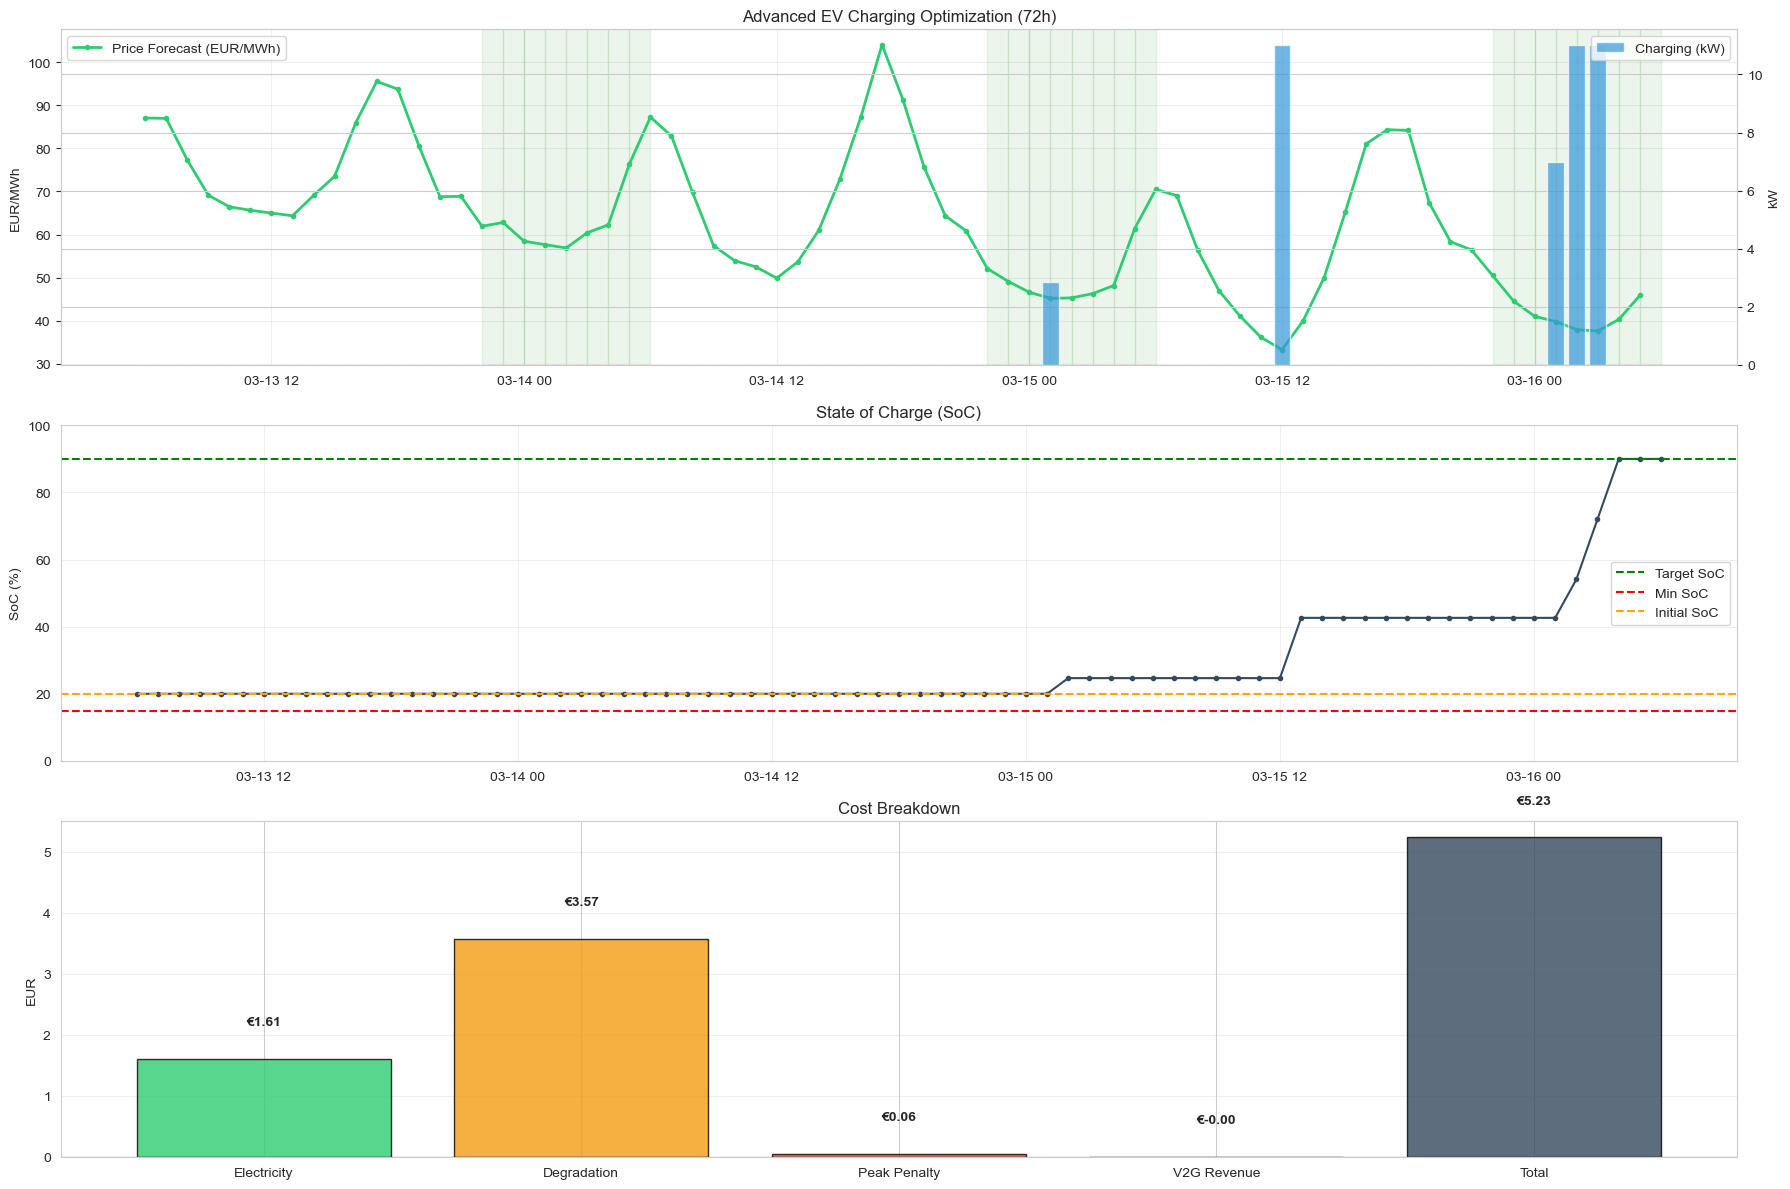

✓ Saved schedule: data/processed/ev_advanced_schedule.csv
✓ Saved summary: data/processed/advanced_optimization_summary.csv


In [1]:
"""
06_optimization_advanced_constraints.ipynb

Advanced EV Charging Optimization with Realistic Constraints:
- Battery degradation cost
- Time-of-use (TOU) preference/penalties
- Minimum SoC constraints over time
- Maximum daily charge limits
- Optional V2G (vehicle-to-grid) discharging
- Exported artifacts (plots + CSV/summary)

"""

# %% Setup and Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
import joblib
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 12)

# %% Load data and models (consistent with training workflow)

df = pd.read_csv('data/processed/electricity_prices_features.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

target_col = 'price_eur_mwh'
timestamp_col = 'timestamp'
feature_cols = [c for c in df.columns if c not in [target_col, timestamp_col]]

# Sequential split as before
split1 = int(len(df) * 0.7)
split2 = int(len(df) * 0.85)
train = df.iloc[:split1]
val   = df.iloc[split1:split2]
test  = df.iloc[split2:]

# Load trained models
lgb_model = joblib.load('models/lightgbm_model.pkl')
xgb_model = joblib.load('models/xgboost_model.pkl')

print("Models loaded and test set prepared.")

# %% 72-hour forecast using ensemble (LGB + XGB)

FORECAST_HORIZON = 72
if len(test) < FORECAST_HORIZON:
    FORECAST_HORIZON = len(test)

X_h = test[feature_cols].iloc[:FORECAST_HORIZON]
y_actual = test[target_col].iloc[:FORECAST_HORIZON].to_numpy()
time_index = test[timestamp_col].iloc[:FORECAST_HORIZON].reset_index(drop=True)

# Forecasts
price_lgb = lgb_model.predict(X_h)
price_xgb = xgb_model.predict(X_h)
price_forecast = (price_lgb + price_xgb) / 2.0

print(f"Forecast MAE (LGB): €{mean_absolute_error(y_actual, price_lgb):.2f}/MWh")
print(f"Forecast MAE (XGB): €{mean_absolute_error(y_actual, price_xgb):.2f}/MWh")
print(f"Forecast MAE (Ensemble): €{mean_absolute_error(y_actual, price_forecast):.2f}/MWh")

# %% EV and battery parameters

EV_BATTERY_KWH    = 60.0    # kWh
EV_INITIAL_SOC    = 0.20    # 20%
EV_TARGET_SOC     = 0.90    # 90%
EV_MIN_SOC        = 0.15    # 15%
EV_CHARGE_POWER_KW= 11.0    # kW
EFFICIENCY        = 0.98    # charging efficiency

# Battery degradation parameters (linear proxy)
BATTERY_COST_EUR      = 8000.0
BATTERY_CYCLE_LIFE    = 2000
DEPTH_OF_DISCHARGE    = 0.8
DEGRADATION_COST_PER_KWH = BATTERY_COST_EUR / (BATTERY_CYCLE_LIFE * EV_BATTERY_KWH * DEPTH_OF_DISCHARGE)

kWh_needed     = EV_BATTERY_KWH * (EV_TARGET_SOC - EV_INITIAL_SOC)
kWh_to_charge  = kWh_needed / EFFICIENCY

print(f"Energy needed to deliver: {kWh_needed:.2f} kWh; energy to charge (incl. losses): {kWh_to_charge:.2f} kWh")

# %% Time-of-Use (TOU) preference windows

hour_of_day = np.array([t.hour for t in time_index])

# Example TOU profile: Off-peak (22:00-06:00), Peak (10-14, 18-22)
is_offpeak = ((hour_of_day >= 22) | (hour_of_day < 6)).astype(int)
is_peak = (((hour_of_day >= 10) & (hour_of_day < 14)) | ((hour_of_day >= 18) & (hour_of_day < 22))).astype(int)

PREFER_OFFPEAK  = True
OFFPEAK_PENALTY_EUR_PER_MWH = 5.0  # penalty for peak charging to encourage off-peak
print(f"Off-peak hours: {is_offpeak.sum()}, Peak hours: {is_peak.sum()}")

# %% Daily maximum charging constraint

MAX_DAILY_CHARGE_KWH = 40.0  # limit per day to reduce stress

# %% Optional V2G settings

ENABLE_V2G = False
V2G_DISCHARGE_RATE_KW = 11.0
V2G_EFFICIENCY        = 0.92  # round-trip components handled via effective SoC change

# %% Optimization model (LP/MILP with PuLP)

model = pulp.LpProblem('EV_Advanced_Charging', pulp.LpMinimize)

# Decision variables
charge_kw = pulp.LpVariable.dicts('charge', range(FORECAST_HORIZON), lowBound=0, upBound=EV_CHARGE_POWER_KW, cat='Continuous')

if ENABLE_V2G:
    discharge_kw = pulp.LpVariable.dicts('discharge', range(FORECAST_HORIZON), lowBound=0, upBound=V2G_DISCHARGE_RATE_KW, cat='Continuous')
else:
    discharge_kw = {i: 0 for i in range(FORECAST_HORIZON)}

# SoC trajectory
soc = pulp.LpVariable.dicts('soc', range(FORECAST_HORIZON + 1), lowBound=EV_MIN_SOC, upBound=1.0, cat='Continuous')

# Objective components
electricity_cost = pulp.lpSum((price_forecast[i] / 1000.0) * charge_kw[i] for i in range(FORECAST_HORIZON))
degradation_cost = pulp.lpSum(DEGRADATION_COST_PER_KWH * charge_kw[i] for i in range(FORECAST_HORIZON))

if ENABLE_V2G:
    v2g_revenue = pulp.lpSum((price_forecast[i] / 1000.0) * 0.8 * discharge_kw[i] for i in range(FORECAST_HORIZON))  # 80% compensation
else:
    v2g_revenue = 0

peak_penalty = pulp.lpSum((OFFPEAK_PENALTY_EUR_PER_MWH / 1000.0) * is_peak[i] * charge_kw[i] for i in range(FORECAST_HORIZON)) if PREFER_OFFPEAK else 0

model += electricity_cost + degradation_cost + peak_penalty - v2g_revenue

# Constraints

# Initial SoC
model += soc[0] == EV_INITIAL_SOC

# SoC dynamics
for i in range(FORECAST_HORIZON):
    chg_term = charge_kw[i] * EFFICIENCY
    dch_term = (discharge_kw[i] / V2G_EFFICIENCY) if ENABLE_V2G else 0
    model += soc[i+1] == soc[i] + (chg_term - dch_term) / EV_BATTERY_KWH

# Final SoC target
model += soc[FORECAST_HORIZON] >= EV_TARGET_SOC

# Minimum SoC always enforced by variable bounds; add explicit constraints for clarity
for i in range(FORECAST_HORIZON + 1):
    model += soc[i] >= EV_MIN_SOC

# Max daily charging (3 days in 72 hours)
for day in range(int(np.ceil(FORECAST_HORIZON / 24))):
    start = day * 24
    end   = min((day + 1) * 24, FORECAST_HORIZON)
    model += pulp.lpSum(charge_kw[i] for i in range(start, end)) <= MAX_DAILY_CHARGE_KWH

# Optional mutual exclusivity (approximate) if V2G enabled
if ENABLE_V2G:
    for i in range(FORECAST_HORIZON):
        model += charge_kw[i] + discharge_kw[i] <= EV_CHARGE_POWER_KW * 1.5  # soft deterrent

# Solve
status = model.solve(pulp.PULP_CBC_CMD(msg=0))
print("Solver status:", pulp.LpStatus[status])

# %% Extract schedules

charging_schedule    = np.array([charge_kw[i].varValue for i in range(FORECAST_HORIZON)])
soc_schedule         = np.array([soc[i].varValue for i in range(FORECAST_HORIZON + 1)])
if ENABLE_V2G:
    discharging_schedule = np.array([discharge_kw[i].varValue for i in range(FORECAST_HORIZON)])
else:
    discharging_schedule = np.zeros(FORECAST_HORIZON)

# Costs
total_electricity_cost = float(np.sum(charging_schedule * price_forecast / 1000.0))
total_degradation_cost = float(np.sum(charging_schedule * DEGRADATION_COST_PER_KWH))
total_peak_penalty     = float(np.sum(charging_schedule * is_peak * OFFPEAK_PENALTY_EUR_PER_MWH / 1000.0)) if PREFER_OFFPEAK else 0.0
total_v2g_revenue      = float(np.sum(discharging_schedule * price_forecast / 1000.0 * 0.8)) if ENABLE_V2G else 0.0

total_cost   = total_electricity_cost + total_degradation_cost + total_peak_penalty - total_v2g_revenue
delivered_kWh= float(np.sum(charging_schedule) * EFFICIENCY)

print(f"Delivered energy: {delivered_kWh:.2f} kWh; Final SoC: {soc_schedule[-1]:.1%}; Total cost: €{total_cost:.2f}")

# Baseline: flat charging (respecting efficiency in target)
flat_per_hour = kWh_to_charge / FORECAST_HORIZON
flat_schedule = np.ones(FORECAST_HORIZON) * flat_per_hour
flat_cost     = float(np.sum(flat_schedule * price_forecast / 1000.0) + np.sum(flat_schedule * DEGRADATION_COST_PER_KWH))

# %% Visualization

fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# 1) Price + schedules
ax = axes[0]
ax2 = ax.twinx()
ax.plot(time_index, price_forecast, '-o', color='#2ecc71', linewidth=2, markersize=3, label='Price Forecast (EUR/MWh)')
ax2.bar(time_index, charging_schedule, width=0.8/24, alpha=0.7, color='#3498db', label='Charging (kW)')
if ENABLE_V2G:
    ax2.bar(time_index, -discharging_schedule, width=0.8/24, alpha=0.5, color='#e74c3c', label='Discharging (kW)')
ax.set_ylabel('EUR/MWh')
ax2.set_ylabel('kW')
ax.set_title('Advanced EV Charging Optimization (72h)')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(alpha=0.3)

# Highlight off-peak windows
for i, off in enumerate(is_offpeak):
    if off:
        ax.axvspan(time_index[i], time_index[i] + pd.Timedelta(hours=1), color='green', alpha=0.08)

# 2) SoC trajectory
ax = axes[1]
ax.plot(pd.date_range(time_index.iloc[0], periods=FORECAST_HORIZON+1, freq='H'), soc_schedule * 100, '-o', color='#34495e', markersize=3)
ax.axhline(EV_TARGET_SOC * 100, color='green', linestyle='--', label='Target SoC')
ax.axhline(EV_MIN_SOC * 100, color='red', linestyle='--', label='Min SoC')
ax.axhline(EV_INITIAL_SOC * 100, color='orange', linestyle='--', label='Initial SoC')
ax.set_ylabel('SoC (%)')
ax.set_ylim([0, 100])
ax.set_title('State of Charge (SoC)')
ax.legend()
ax.grid(alpha=0.3)

# 3) Cost breakdown
ax = axes[2]
labels = ['Electricity', 'Degradation', 'Peak Penalty', 'V2G Revenue', 'Total']
values = [total_electricity_cost, total_degradation_cost, total_peak_penalty, -total_v2g_revenue, total_cost]
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#34495e']
bars = ax.bar(labels, values, color=colors, alpha=0.8, edgecolor='black')
ax.axhline(0, color='black', linewidth=0.8)
for b, v in zip(bars, values):
    ax.text(b.get_x()+b.get_width()/2, v + (0.5 if v>=0 else -0.5), f'€{v:.2f}', ha='center', va='bottom', fontweight='bold')
ax.set_ylabel('EUR')
ax.set_title('Cost Breakdown')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('data/processed/06_advanced_optimization.png', dpi=300, bbox_inches='tight')
print("✓ Saved plot: data/processed/06_advanced_optimization.png")
plt.show()

# %% Export schedule

schedule_df = pd.DataFrame({
    'timestamp': time_index,
    'price_eur_mwh': price_forecast,
    'charge_kw': charging_schedule,
    'discharge_kw': discharging_schedule,
    'soc_percent': soc_schedule[:-1] * 100,
    'is_offpeak': is_offpeak,
    'is_peak': is_peak
})
schedule_df.to_csv('data/processed/ev_advanced_schedule.csv', index=False)
print("✓ Saved schedule: data/processed/ev_advanced_schedule.csv")

# %% Summary

summary = {
    'Forecast Period': f"{time_index.iloc[0]} to {time_index.iloc[-1]}",
    'Horizon (h)': FORECAST_HORIZON,
    'Battery (kWh)': EV_BATTERY_KWH,
    'Initial SoC': f"{EV_INITIAL_SOC:.0%}",
    'Target SoC': f"{EV_TARGET_SOC:.0%}",
    'Min SoC': f"{EV_MIN_SOC:.0%}",
    'Max charge (kW)': EV_CHARGE_POWER_KW,
    'Max daily charge (kWh)': MAX_DAILY_CHARGE_KWH,
    'V2G enabled': ENABLE_V2G,
    'Degradation €/kWh': f"{DEGRADATION_COST_PER_KWH:.4f}",
    'Optimal total cost (EUR)': f"{total_cost:.2f}",
    'Flat cost (EUR)': f"{flat_cost:.2f}",
    'Savings vs Flat (EUR)': f"{flat_cost - total_cost:.2f}",
    'Delivered kWh (optimal)': f"{delivered_kWh:.2f}",
    'Final SoC (optimal)': f"{soc_schedule[-1]:.1%}",
}
summary_df = pd.DataFrame(summary.items(), columns=['Metric', 'Value'])
summary_df.to_csv('data/processed/advanced_optimization_summary.csv', index=False)
print("✓ Saved summary: data/processed/advanced_optimization_summary.csv")
